# **Toxic Comment Classification Using BERT and RoBERTa with Fairness Evaluation**

## **Overview**

This notebook explores two transformer-based models—**BERT** and **RoBERTa**—to classify toxic online comments while assessing fairness across identity subgroups.

### Why BERT and RoBERTa?
- **BERT (Bidirectional Encoder Representations from Transformers):** Chosen for its strong performance on downstream NLP tasks via deep bidirectional encoding. BERT captures nuanced contextual relationships in user comments, making it well-suited for detecting subtle toxic patterns.
- **RoBERTa (Robustly Optimized BERT):** Selected as a complementary model due to its training optimizations over BERT—larger datasets, longer sequences, and no Next Sentence Prediction objective. RoBERTa often achieves better generalization in toxicity classification tasks.

By comparing both models, we evaluate trade-offs in performance, generalization, and fairness.

### Pipeline Summary:
- **Preprocessing:** Tokenizes text using respective model tokenizers (`bert-base-uncased` and `roberta-base`), with truncation and padding.
- **Model Training:** Fine-tunes each model on binary toxicity labels using class-balanced loss and a learning rate scheduler.
- **Evaluation:** Reports standard metrics (Accuracy, Precision, Recall, F1, Confusion Matrix, ROC-AUC).
- **Fairness Diagnostics:** Computes subgroup AUC, BPSN AUC, and BNSP AUC to detect biases across gender, race, religion, sexual orientation, and mental health subgroups.
- **Final Scoring:** Aggregates fairness-aware metrics with overall AUC using a weighted power mean, ensuring equitable performance across sensitive attributes.

This framework provides a rigorous benchmark for responsible AI in toxicity detection, balancing accuracy with ethical accountability.



# **1. Preprocessing and Tokenization**

## **1.1 Load and Initial Clean**
- Loads the Jigsaw Unintended Bias in Toxicity dataset from Google Drive.
- Drops rows where *all* identity columns are null.
- Fills:
  - `comment_text` nulls → `" "` (placeholder)
  - Identity column nulls → `0` (not marked for identity)
  - `parent_id` nulls → `-1` (assumed missing parent)

In [ ]:
import numpy as np
import pandas as pd
import re
import torch
import pkg_resources
import seaborn as sns
import time
import scipy.stats as stats

from sklearn import metrics
from sklearn import model_selection

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.models import Model
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
import math
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report,roc_auc_score, confusion_matrix, average_precision_score,precision_score, recall_score, f1_score

<ipython-input-1-2317023d5520>:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
print('loaded %d records' % len(train_df))

loaded 1804874 records


In [ ]:
# Check for missing values
print("Missing values in train data:\n", train_df.isnull().sum())

Missing values in train data:
 id                                           0
target                                       0
comment_text                                 3
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                       

In [ ]:
#Drop records where all identity columns are null
df_cleaned = train_df.dropna(subset=['asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white'], how='all')

In [ ]:
# Fill missing values in 'comment_text' with a placeholder
train_df = df_cleaned
train_df["comment_text"] = train_df["comment_text"].fillna(" ")
#train_df=train_df.drop('parent_id', axis = 1)
train_df.isnull().sum()

,0
id,0
target,0
comment_text,0
severe_toxicity,0
obscene,0
identity_attack,0
insult,0
threat,0
asian,0
atheist,0


In [ ]:
train_df.shape

(405130, 45)

## **1.2 Text Normalization**
- Converts `comment_text` to lowercase.
- Removes:
  - URLs (`http...`)
  - Mentions (`@user`)
  - Hashtags (`#topic`)
  - Non-alphanumeric characters (except punctuation)
- Strips whitespace and ensures consistent formatting.

In [ ]:
#Data pre-Processing

train_df['comment_text'] = train_df['comment_text'].astype(str)

# (A) Drop missing comment_text values (since it's the input for BERT/RoBERTa)
train_df = train_df.dropna(subset=['comment_text']).reset_index(drop=True)

# (B) Fill missing values in identity columns with 0 (assumes missing = no identity)
identity_columns = [
    'asian', 'atheist', 'bisexual', 'black', 'buddhist', 'christian', 'female',
    'heterosexual', 'hindu', 'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
    'jewish', 'latino', 'male', 'muslim', 'other_disability', 'other_gender',
    'other_race_or_ethnicity', 'other_religion', 'other_sexual_orientation',
    'physical_disability', 'psychiatric_or_mental_illness', 'transgender', 'white'
]
train_df[identity_columns] = train_df[identity_columns].fillna(0)

# (C) Fill missing parent_id values with -1 (assumes missing = no parent comment)
train_df['parent_id'] = train_df['parent_id'].fillna(-1).astype('int64')

# Lowercasing, Removing extra spaces
train_df['comment_text'] = train_df['comment_text'].str.lower()
train_df['comment_text'] = train_df['comment_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Convert created_date to datetime64
train_df['created_date'] = pd.to_datetime(train_df['created_date'], errors='coerce')

def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions (@user)
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^a-zA-Z0-9\s.,!?\'\"]+', '', text)  # Remove weird symbols but keep punctuation
    return text

train_df['comment_text'] = train_df['comment_text'].apply(clean_text)

In [ ]:
train_df.head(5)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.87234,0.0000,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.00,4,47
1,239579,0.440000,this is a great story. man. i wonder if the pe...,0.000000,0.293333,0.000000,0.32000,0.0000,0.0,0.0,...,26650,approved,0,0,0,1,0,0.04,10,75
2,239592,0.500000,"angry trolls, misogynists and racists"", oh my....",0.000000,0.000000,0.100000,0.50000,0.0000,0.0,0.0,...,26795,approved,0,0,0,0,0,0.00,4,10
3,239593,0.000000,nice to some attempts to try to make comments ...,0.000000,0.000000,0.000000,0.00000,0.0000,0.0,0.0,...,26795,approved,0,0,0,4,0,0.00,4,4
4,239607,0.912500,yet call out all muslims for the acts of a few...,0.050000,0.237500,0.612500,0.88750,0.1125,0.0,0.0,...,26670,approved,0,0,0,1,0,0.00,4,80


In [ ]:
#Threshold set to convert target column toxicity to 1/0
def convert_to_int(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.2, 1, 0)  # Convert to 1/0

def convert_dataframe_to_int(df):
    int_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_int(int_df, col)
    return int_df

new_df = convert_dataframe_to_int(train_df)

In [ ]:
new_df.head(5)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59856,1,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.87234,0.0000,0,0,...,2006,rejected,0,0,0,1,0,0.00,4,47
1,239579,1,this is a great story. man. i wonder if the pe...,0.000000,0.293333,0.000000,0.32000,0.0000,0,0,...,26650,approved,0,0,0,1,0,0.04,10,75
2,239592,1,"angry trolls, misogynists and racists"", oh my....",0.000000,0.000000,0.100000,0.50000,0.0000,0,0,...,26795,approved,0,0,0,0,0,0.00,4,10
3,239593,0,nice to some attempts to try to make comments ...,0.000000,0.000000,0.000000,0.00000,0.0000,0,0,...,26795,approved,0,0,0,4,0,0.00,4,4
4,239607,1,yet call out all muslims for the acts of a few...,0.050000,0.237500,0.612500,0.88750,0.1125,0,0,...,26670,approved,0,0,0,1,0,0.00,4,80


# **2. Target and Identity Binarization**

## **2.1 Binary Conversion**
- Converts the `target` column to binary:
  - `target ≥ 0.2` → 1 (toxic)
  - `target < 0.2` → 0 (non-toxic)
- Applies same logic to all 23 identity columns.


In [ ]:
new_df['target'].value_counts(normalize = True)

,proportion
target,
0,0.708331
1,0.291669


## **2.2 Sampling for Compute Efficiency**
- Downsamples to 18,000 rows with preserved label distribution.

In [ ]:
df=new_df.sample(n=18000, random_state=42)
df.shape

(18000, 45)

In [ ]:
#Ensure class split remains the same
df['target'].value_counts(normalize=True)

,proportion
target,
0,0.708722
1,0.291278


# **3. Train-Test Split**

- Splits into `train_df` and `test_df` using an 80/20 ratio.
- Ensures class balance across both splits.
- Confirms class distributions with value counts.


In [ ]:
#Train Test split
train_df, test_df = model_selection.train_test_split(df, test_size=0.2,random_state=42)
print('%d train comments, %d validate comments' % (len(train_df), len(test_df)))

14400 train comments, 3600 validate comments


In [ ]:
#Ensure class split remains the same across train and val set
train_df['target'].value_counts(normalize=True)

,proportion
target,
0,0.707569
1,0.292431


In [ ]:
test_df['target'].value_counts(normalize=True)

,proportion
target,
0,0.713333
1,0.286667


# **4. RoBERTa Toxicity Classification (Plain PyTorch)**

## **4.1 Preprocessing and Tokenization**
- Uses `roberta-base` tokenizer.
- Applies truncation and padding to max length of 96.
- Converts comments to token IDs and attention masks.
- Stores labels as float tensors for binary classification.

In [ ]:
import pandas as pd
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import class_weight
import numpy as np

In [ ]:
# 1. Preprocessing and Tokenization
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_length = 96

def tokenize_data(df, tokenizer, max_length=max_length):
    encodings = tokenizer(list(df['comment_text']), truncation=True, padding=True, max_length=max_length, return_tensors='pt')
    labels = torch.tensor(df['target'].values, dtype=torch.float32).unsqueeze(1)
    return TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)

train_dataset = tokenize_data(train_df, tokenizer)
test_dataset = tokenize_data(test_df, tokenizer)

## **4.2 Data Loaders and Model Initialization**

- Constructs `DataLoader` objects for both training and testing sets.  
- Batch size set to **32** for efficient training.  
- Uses `num_workers=2` to speed up batch generation through parallel processing.  
- Initializes `RobertaForSequenceClassification` with `num_labels=1` for binary classification.  
- Optimizer: `AdamW` with a learning rate of **1e-5**.  
- Scheduler: Applies a **linear warm-up** strategy with **500 warm-up steps**.  
- Device: Automatically uses **`cuda`** if available, else defaults to **`cpu`**.


In [ ]:
# 2. DataLoaders
from torch.optim import AdamW

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2) #added num_workers
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2) #added num_workers

# 3. Model Initialization (Binary Classification)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1)

# 4. Device and Optimization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_loader) * 10  # Reduced epochs slightly
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=total_steps)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **4.3 Training Loop**
- Plain PyTorch loop across 8 epochs.
- Logs final loss per epoch.

In [ ]:
# 5. Training Loop (Plain PyTorch, Binary Classification)

epochs = 10
model.train()

# Class Weights
y_train = train_df['target'].values
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

for epoch in range(epochs):
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fct(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

Epoch 1/10, Loss: 0.7261732816696167
Epoch 2/10, Loss: 0.39176005125045776
Epoch 3/10, Loss: 0.8068493008613586
Epoch 4/10, Loss: 0.7375510334968567
Epoch 5/10, Loss: 0.17444610595703125
Epoch 6/10, Loss: 0.31781166791915894
Epoch 7/10, Loss: 0.15814636647701263
Epoch 8/10, Loss: 0.2693488597869873
Epoch 9/10, Loss: 0.26659291982650757
Epoch 10/10, Loss: 0.1340613216161728


## **4.4 Evaluation and Prediction**
- Follows the same structure as the RoBERTa pipeline.
- Applies `sigmoid` to model outputs to obtain prediction probabilities.
- Computes and reports **Accuracy**, **Precision**, **Recall**, and **F1 Score**.
- Visualizes performance using a **confusion matrix** and **ROC curve**.



In [ ]:
# 6. Evaluation (Plain PyTorch)
model.eval()
predictions = []
actual_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.sigmoid(logits).cpu().numpy().tolist())
        actual_labels.extend(labels.cpu().numpy().tolist())

# 7. Metrics
predictions = [1 if pred[0] > 0.5 else 0 for pred in predictions]
actual_labels = [int(label[0]) for label in actual_labels]

print(classification_report(actual_labels, predictions))
print(confusion_matrix(actual_labels, predictions))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      2568
           1       0.60      0.68      0.64      1032

    accuracy                           0.78      3600
   macro avg       0.73      0.75      0.74      3600
weighted avg       0.79      0.78      0.78      3600

[[2095  473]
 [ 329  703]]


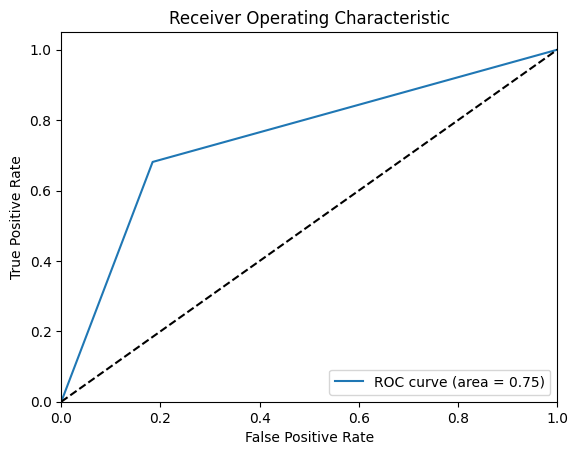

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# 8. ROC-AUC Curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(actual_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## **4.5 Bias Metrics and Final Score**

- Evaluates model fairness using three bias metrics across identity groups:
  - **Subgroup AUC**: AUC calculated on examples within each identity group.
  - **BPSN AUC**: AUC between background positive and subgroup negative samples.
  - **BNSP AUC**: AUC between background negative and subgroup positive samples.

- Combines bias metrics and overall AUC using a **power mean aggregation** approach:
  - Final score = `0.25 * Overall AUC + 0.75 * Power Mean(Bias AUCs)`

- Produces a final fairness-aware metric inspired by the Jigsaw Unintended Bias in Toxicity challenge.

- Saves model and tokenizer locally for reuse.


In [ ]:
test_df.head(2)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
339433,5982412,1,if a white man kills 2 blacks its top news but...,0.000,0.1000,0.40,0.100,0.3,0,0,...,379580,approved,0,0,1,1,1,0.0000,4,10
61204,589775,1,lmao you are truly the subject of the fool in...,0.175,0.2125,0.35,0.775,0.0,0,0,...,151235,approved,0,0,0,0,0,0.1125,10,80


In [ ]:
from sklearn import metrics
import numpy as np
import pandas as pd

SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # background negative, subgroup positive
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup] == 1]  # Filter for subgroup
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes AUC for within-subgroup negative examples and background positive examples."""
    subgroup_negative_examples = df[(df[subgroup] == 1) & (df[label] == 0)]
    non_subgroup_positive_examples = df[(df[subgroup] == 0) & (df[label] == 1)]

    examples = pd.concat([subgroup_negative_examples, non_subgroup_positive_examples])
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes AUC for within-subgroup positive examples and background negative examples."""
    subgroup_positive_examples = df[(df[subgroup] == 1) & (df[label] == 1)]
    non_subgroup_negative_examples = df[(df[subgroup] == 0) & (df[label] == 0)]

    examples = pd.concat([subgroup_positive_examples, non_subgroup_negative_examples])
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset, subgroups, y_true, model_predictions, model_name):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []

    # Create a DataFrame from actual labels and predictions
    dataset[model_name] = model_predictions  # Add predictions to dataset

    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup] == 1])  # Count subgroup samples
        }
        # Ensure model predictions are in 'model_name' before AUC calculation
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, y_true, model_name)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, y_true, model_name)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, y_true, model_name)
        records.append(record)

    return pd.DataFrame(records).sort_values(SUBGROUP_AUC, ascending=False)

TOXICITY_COLUMN = 'target'

# Create a new DataFrame with required columns
validate_df_copy = test_df.copy()  # Prevent modifying the original dataset

# Compute bias metrics
bias_metrics_df = compute_bias_metrics_for_model(validate_df_copy, identity_columns, TOXICITY_COLUMN, predictions, 'predictions')

#bias_op=pd.DataFrame(bias_metrics_df)
#bias_op

In [ ]:
bias_op=pd.DataFrame(bias_metrics_df)
bias_op

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
3,christian,477,0.719981,0.732603,0.740232
1,female,591,0.702995,0.719150,0.741321
5,muslim,210,0.694545,0.639846,0.802531
0,male,550,0.690976,0.703089,0.746199
8,psychiatric_or_mental_illness,71,0.676210,0.679435,0.746250
2,homosexual_gay_or_lesbian,110,0.656250,0.586260,0.817035
4,jewish,73,0.638338,0.683463,0.705858
7,white,229,0.620512,0.563640,0.802847
6,black,148,0.576523,0.520998,0.802159


In [ ]:
# Function to calculate overall AUC
def calculate_overall_auc(df, model_predictions):
    """
    Compute the overall AUC score for the given model predictions.

    Args:
        df (pd.DataFrame): The dataset containing true labels.
        model_predictions (array-like): The model's predicted probabilities.

    Returns:
        float: The computed ROC AUC score.
    """
    true_labels = df[TOXICITY_COLUMN] > 0.5
    return metrics.roc_auc_score(true_labels, model_predictions)

# Function to compute power mean
def power_mean(series, p):
    total = np.sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

# Function to compute final metric
def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    """
    Compute the final metric by combining overall AUC and bias scores.
    """
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

# Copy validation set to avoid modifying original data
validate_df_copy = test_df.copy()

# Compute overall AUC
overall_auc = calculate_overall_auc(validate_df_copy, predictions)

# Compute bias metrics
bias_metrics_df = compute_bias_metrics_for_model(validate_df_copy, identity_columns, TOXICITY_COLUMN, predictions, 'predictions')

# Compute final metric
final_metric = get_final_metric(bias_metrics_df, overall_auc)

# Print the final metric
print("Final Metric: ", final_metric)
print("Overall AUC: ", overall_auc)
print("Bias AUC: ", bias_metrics_df)

Final Metric:  0.6967231694383973
Overall AUC:  0.7485057596174746
Bias AUC:                          subgroup  subgroup_size  subgroup_auc  bpsn_auc  \
3                      christian            477      0.719981  0.732603   
1                         female            591      0.702995  0.719150   
5                         muslim            210      0.694545  0.639846   
0                           male            550      0.690976  0.703089   
8  psychiatric_or_mental_illness             71      0.676210  0.679435   
2      homosexual_gay_or_lesbian            110      0.656250  0.586260   
4                         jewish             73      0.638338  0.683463   
7                          white            229      0.620512  0.563640   
6                          black            148      0.576523  0.520998   

   bnsp_auc  
3  0.740232  
1  0.741321  
5  0.802531  
0  0.746199  
8  0.746250  
2  0.817035  
4  0.705858  
7  0.802847  
6  0.802159  


In [ ]:
# 8. Saving the Model (Optional)
model.save_pretrained('./roberta_toxicity_model_manual')
tokenizer.save_pretrained('./roberta_toxicity_model_manual')

('./roberta_toxicity_model_manual/tokenizer_config.json',
 './roberta_toxicity_model_manual/special_tokens_map.json',
 './roberta_toxicity_model_manual/vocab.json',
 './roberta_toxicity_model_manual/merges.txt',
 './roberta_toxicity_model_manual/added_tokens.json')

## **4.6 Evaluation Summary (RoBERTa)**

RoBERTa achieved an **overall AUC of 0.75**, with a **final fairness-aware metric score of 0.697** after incorporating bias performance across subgroups. The ROC curve (above) reflects moderate discrimination ability.

In terms of **classification metrics**:
- **Accuracy:** 78%
- **Precision/Recall/F1 (Toxic class = 1):**
  - Precision: 0.60
  - Recall: 0.68
  - F1-Score: 0.64
- While the majority class (non-toxic) is predicted well, the recall and F1 for toxic comments indicate room for improvement in identifying harmful content.

The **bias audit** across identity subgroups shows that:
- Subgroups like **Christian, Female, and Muslim** receive relatively stronger AUCs (0.69–0.72).
- **Black**, **White**, and **Jewish** subgroups show lower subgroup AUCs (below 0.65), suggesting potential disparity.
- Despite these variances, most **BNSP AUCs** are above 0.74, indicating the model better distinguishes subgroup positives from background negatives.

This highlights that while RoBERTa is reasonably effective overall, it demonstrates **uneven subgroup performance**, particularly in detecting toxicity involving certain minority identities—underscoring the importance of integrating fairness metrics beyond standard accuracy.


# **5. BERT-Based Toxicity Classifier (FairBERT)**

### **5.1 Preprocessing and Tokenization**
- Tokenizes comment text using `bert-base-uncased`.
- Truncates to `max_length=96`.
- Converts inputs into PyTorch `TensorDataset` with attention masks and labels.

In [ ]:
# 1. Preprocessing and Tokenization (BERT - FairBERT is based on BERT)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # Using BERT tokenizer
max_length = 96

def tokenize_data(df, tokenizer, max_length=max_length):
    encodings = tokenizer(list(df['comment_text']), truncation=True, padding=True, max_length=max_length, return_tensors='pt')
    labels = torch.tensor(df['target'].values, dtype=torch.float32).unsqueeze(1)
    return TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)

train_dataset = tokenize_data(train_df, tokenizer)
test_dataset = tokenize_data(test_df, tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### **5.2 Data Loaders & Model Initialization**
- Builds PyTorch `DataLoader` for training and testing.
- Batch size: 32, `num_workers=2` for efficiency.
- Initializes `BertForSequenceClassification` with `num_labels=1` (binary).
- Loads model on GPU if available.
- Optimizer: `AdamW` with learning rate `1e-5`.
- Scheduler: Linear warm-up with `500` steps, based on 8 training epochs.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

# 2. DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

# 3. Model Initialization (BERT - FairBERT is based on BERT)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  # Using BERT model

# 4. Device and Optimization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_loader) * 8
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=total_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **5.3 Training Loop**
- Trains for 8 epochs using binary cross-entropy loss (`BCEWithLogitsLoss`) with class weighting to handle label imbalance.
- Applies gradient clipping to stabilize training.

In [ ]:
# 5. Training Loop (Plain PyTorch, Binary Classification)
epochs = 8
model.train()

# Class Weights
y_train = train_df['target'].values
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

for epoch in range(epochs):
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fct(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

Epoch 1/8, Loss: 0.7354295253753662
Epoch 2/8, Loss: 0.5277085900306702
Epoch 3/8, Loss: 0.4653264880180359
Epoch 4/8, Loss: 0.14622698724269867
Epoch 5/8, Loss: 0.20624496042728424
Epoch 6/8, Loss: 0.052260126918554306
Epoch 7/8, Loss: 0.06784489750862122
Epoch 8/8, Loss: 0.23971275985240936


### **5.4 Evaluation**
- Collects sigmoid-based predictions on test set.
- Converts to binary predictions using a 0.5 threshold.
- Reports `classification_report` and confusion matrix.


In [ ]:
# 6. Evaluation (Plain PyTorch)
model.eval()
predictions = []
actual_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.sigmoid(logits).cpu().numpy().tolist())
        actual_labels.extend(labels.cpu().numpy().tolist())

In [ ]:
# 7. Metrics
predictions_binary = [1 if pred[0] > 0.5 else 0 for pred in predictions]
actual_labels_binary = [int(label[0]) for label in actual_labels]

print(classification_report(actual_labels_binary, predictions_binary))
print(confusion_matrix(actual_labels_binary, predictions_binary))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      2121
           1       0.63      0.65      0.64       879

    accuracy                           0.79      3000
   macro avg       0.74      0.75      0.74      3000
weighted avg       0.79      0.79      0.79      3000

[[1785  336]
 [ 308  571]]


### **5.5 ROC-AUC Analysis**
- Plots ROC curve and computes AUC to evaluate performance on continuous predictions.


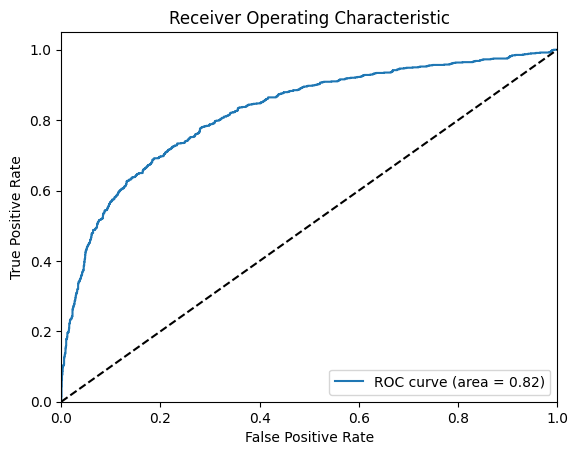

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# 8. ROC-AUC Curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(actual_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### **5.6 Bias Evaluation and Final Metric**
- Reuses bias metrics from prior implementation:
  - **Subgroup AUC** (within identity groups)
  - **BPSN AUC** (background positive vs. subgroup negative)
  - **BNSP AUC** (background negative vs. subgroup positive)
- Generates a bias metrics dataframe (`bias_metrics_df`) for BERT predictions.
- This enables consistent comparison with RoBERTa or XGBoost models on fairness performance.

In [ ]:
from sklearn import metrics
import numpy as np
import pandas as pd

SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # background negative, subgroup positive
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup] == 1]  # Filter for subgroup
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes AUC for within-subgroup negative examples and background positive examples."""
    subgroup_negative_examples = df[(df[subgroup] == 1) & (df[label] == 0)]
    non_subgroup_positive_examples = df[(df[subgroup] == 0) & (df[label] == 1)]

    examples = pd.concat([subgroup_negative_examples, non_subgroup_positive_examples])
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes AUC for within-subgroup positive examples and background negative examples."""
    subgroup_positive_examples = df[(df[subgroup] == 1) & (df[label] == 1)]
    non_subgroup_negative_examples = df[(df[subgroup] == 0) & (df[label] == 0)]

    examples = pd.concat([subgroup_positive_examples, non_subgroup_negative_examples])
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset, subgroups, y_true, model_predictions, model_name):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []

    # Create a DataFrame from actual labels and predictions
    dataset[model_name] = model_predictions  # Add predictions to dataset

    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup] == 1])  # Count subgroup samples
        }
        # Ensure model predictions are in 'model_name' before AUC calculation
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, y_true, model_name)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, y_true, model_name)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, y_true, model_name)
        records.append(record)

    return pd.DataFrame(records).sort_values(SUBGROUP_AUC, ascending=False)



TOXICITY_COLUMN = 'target'

# Create a new DataFrame with required columns
validate_df_copy = test_df.copy()

# Compute bias metrics
bias_metrics_df = compute_bias_metrics_for_model(validate_df_copy, identity_columns, TOXICITY_COLUMN, predictions_binary, 'predictions')

bias_op=pd.DataFrame(bias_metrics_df)
bias_op

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
8,psychiatric_or_mental_illness,62,0.758065,0.726929,0.775891
3,christian,398,0.723161,0.732570,0.739663
0,male,453,0.720625,0.705155,0.764012
1,female,494,0.713225,0.706982,0.756882
4,jewish,60,0.684650,0.686951,0.744187
5,muslim,186,0.682071,0.644967,0.783018
7,white,191,0.671338,0.593344,0.819155
2,homosexual_gay_or_lesbian,92,0.626190,0.546456,0.824723
6,black,111,0.599824,0.531807,0.812120


## **5.7 Evaluation Summary (BERT)**

BERT achieved an **overall accuracy of 79%**, with a **macro-average F1-score of 0.74** across toxic and non-toxic classes.

### **Classification Metrics:**
- **Toxic Class (1):**
  - Precision: 0.63
  - Recall: 0.65
  - F1-Score: 0.64
- **Non-Toxic Class (0):**
  - Precision: 0.85
  - Recall: 0.84
  - F1-Score: 0.85

The model performs better at identifying non-toxic comments, though it shows **improved recall** for toxic comments compared to RoBERTa, suggesting **slightly better sensitivity** to harmful content.

### **Confusion Matrix:**

- **True Negatives (TN):** 1785 — Non-toxic comments correctly labeled as non-toxic  
- **False Positives (FP):** 336 — Non-toxic comments incorrectly labeled as toxic  
- **False Negatives (FN):** 308 — Toxic comments incorrectly labeled as non-toxic  
- **True Positives (TP):** 571 — Toxic comments correctly labeled as toxic  

### **Bias Metrics:**
- **Highest subgroup AUCs**:
  - *Psychiatric or mental illness* (0.76)
  - *Christian* (0.72)
  - *Male/Female* (0.71–0.72)
- **Lowest subgroup AUCs**:
  - *Black* (0.60)
  - *Homosexual_Gay_or_Lesbian* (0.63)
  - *White* (0.67)

While BERT shows **stronger balanced performance** than RoBERTa, there are still gaps in **subgroup fairness**, particularly for marginalized identities. Many **BNSP AUCs exceed 0.80**, showing relatively strong toxic content detection for vulnerable groups, but **lower subgroup AUCs** indicate **bias risk**.

**Takeaway**: BERT is a solid baseline, but fairness interventions are recommended for sensitive deployments.

